In [1]:
import time

start = time.time()

In [8]:
# !pip install torch
!pip install tqdm
!pip install --no-deps gcastle==1.0.3rc3
# !pip install pytz
# !pip install networkx
# !pip install pyyaml
# !pip install lingam
# !apt-get update && apt-get install -y graphviz 

  Using cached tqdm-4.64.0-py2.py3-none-any.whl (78 kB)
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

gcastle 1.0.3rc3 requires scipy>=1.7.3, but you'll have scipy 1.5.4 which is incompatible.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import os
import logging
from pytz import timezone
from datetime import datetime
import numpy as np

from data_loader import SyntheticDataset
#from models import NoTears
from trainers import ALTrainer
from helpers.config_utils import save_yaml_config, get_train_args
from helpers.log_helper import LogHelper
from helpers.tf_utils import set_seed
from helpers.dir_utils import create_dir
from helpers.analyze_utils import count_accuracy, plot_estimated_graph

# For logging of tensorflow messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
import pandas as pd


exp_name = 'n_500_d_5_e_3_ER'

# exp_name = 'n_500_d_20_e_12_ER'
# exp_name = 'n_500_d_20_e_12_SF'
# exp_name = 'n_500_d_100_e_60_ER'
# exp_name = 'n_500_d_100_e_60_SF'
# exp_name = 'n_500_d_300_e_180_ER'
# exp_name = 'n_500_d_300_e_180_SF'

# exp_name = 'n_2000_d_20_e_12_ER'
# exp_name = 'n_2000_d_20_e_12_SF'
# exp_name = 'n_2000_d_100_e_60_ER'
# exp_name = 'n_2000_d_100_e_60_SF'
# exp_name = 'n_2000_d_300_e_180_ER'
# exp_name = 'n_2000_d_300_e_180_SF'

dataset_path = '../../experiment/datasets/{}/X.csv'.format(exp_name)
true_path = '../../experiment/datasets/{}/W_true.csv'.format(exp_name)

# headers = pd.read_csv(dataset_path, nrows=0).columns.tolist()
# headers = [c for c in headers if c != 'Samples']
# df = pd.read_csv(dataset_path, usecols=headers)

df = pd.read_csv(dataset_path, header=None)
df = df.fillna(-1).reset_index(drop=True)
df = (df-df.mean())/df.std()
X = df.to_numpy()

headers = []
for i in range(X.shape[1]):
    headers.append('x{}'.format(i))

X.shape

(500, 5)

In [5]:
# Setup for logging
output_dir = 'output/nt/{}'.format(exp_name)
create_dir(output_dir)
LogHelper.setup(log_path='{}/training.log'.format(output_dir), level_str='INFO')
_logger = logging.getLogger(__name__)

2022-04-12 02:45:13,305 INFO - helpers.log_helper - Finished configuring logger.


In [6]:
from castle.algorithms import NotearsNonlinear

nt = NotearsNonlinear(device_type='gpu', model_type='mlp', w_threshold=0.0)
nt.learn(X)

W_est = np.array(nt.weight_causal_matrix)
W_est

2022-04-12 02:45:13,646 INFO - root - You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2022-04-12 02:45:14,135 INFO - root - You are using ``pytorch`` as the backend.
2022-04-12 02:45:14,185 INFO - root - GPU is available.
2022-04-12 02:45:16,367 INFO - root - [start]: n=500, d=5, iter_=100, h_=1e-08, rho_=1e+16
2022-04-12 02:45:22,479 INFO - root - FINISHED


array([[0.000e+00, 8.785e-05, 5.018e-05, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 1.213e+00, 0.000e+00, 0.000e+00],
       [1.057e+00, 5.241e-05, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 9.838e-01, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]])

In [7]:
# from castle.algorithms import GraNDAG

# # Instantiation algorithm
# gnd = GraNDAG(input_dim=X.shape[1], iterations=100, use_pns=False)
# gnd.learn(data=X)

# W_est = np.array(nt.weight_causal_matrix)
# W_est

In [8]:
w_true = pd.read_csv(true_path, header=None)
w_true = w_true.to_numpy()
w_true

array([[ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.723,  0.   ,  0.   ],
       [-0.554,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.471,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ]])

In [9]:
# Save raw estimated graph, ground truth and observational data after training
np.save('{}/true_graph.npy'.format(output_dir), w_true)
np.save('{}/X.npy'.format(output_dir), X)
np.save('{}/final_raw_estimated_graph.npy'.format(output_dir), W_est)

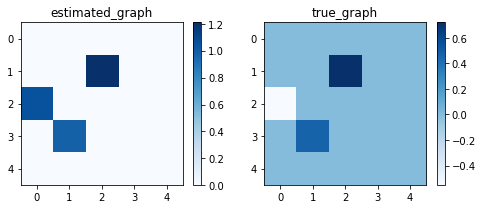

2022-04-12 02:45:23,002 INFO - __main__ - Thresholding.


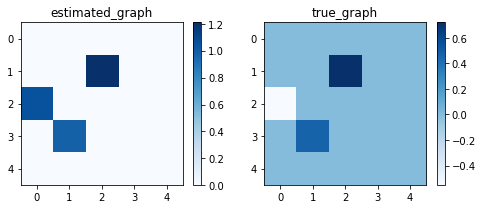

2022-04-12 02:45:23,482 INFO - __main__ - Results after thresholding by 0.0: {'fdr': 0.5, 'tpr': 1.0, 'fpr': 0.42857142857142855, 'shd': 3, 'pred_size': 6}


In [10]:
# Plot raw estimated graph
plot_estimated_graph(W_est, w_true,
                     save_name='{}/raw_estimated_graph.png'.format(output_dir))

_logger.info('Thresholding.')
# Plot thresholded estimated graph
graph_thres = 0.0
copy_W_est = np.copy(W_est)
copy_W_est[np.abs(copy_W_est) < graph_thres] = 0   # Thresholding
plot_estimated_graph(copy_W_est, w_true,
                     save_name='{}/thresholded_estimated_graph.png'.format(output_dir))
results_thresholded = count_accuracy(w_true, copy_W_est)
_logger.info('Results after thresholding by {}: {}'.format(graph_thres, results_thresholded))

In [11]:
end = time.time()

_logger.info('The time used to execute this is given below')
_logger.info(end - start)

2022-04-12 02:45:23,487 INFO - __main__ - The time used to execute this is given below
2022-04-12 02:45:23,488 INFO - __main__ - 11.967530012130737


In [12]:
c = np.sum(copy_W_est, axis=1)
c.shape

(5,)

In [13]:
copy_W_est

array([[0.000e+00, 8.785e-05, 5.018e-05, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 1.213e+00, 0.000e+00, 0.000e+00],
       [1.057e+00, 5.241e-05, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 9.838e-01, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]])

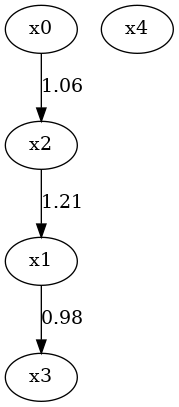

In [14]:
from lingam.utils import make_dot

dot = make_dot(copy_W_est, labels=headers, lower_limit=0.5)

# Save png
dot.format = 'png'
dag_path = dot.render('{}/dag'.format(output_dir))

#dot.render('{}/dag'.format(output_dir))

from IPython.display import Image
Image(filename=dag_path) 

2022-04-13 13:47:51,054 INFO - helpers.log_helper - Finished configuring logger.
2022-04-13 13:47:51,054 INFO - helpers.log_helper - Finished configuring logger.
2022-04-13 13:47:51,054 INFO - helpers.log_helper - Finished configuring logger.
2022-04-13 13:47:51,054 INFO - helpers.log_helper - Finished configuring logger.
2022-04-13 13:47:51,054 INFO - helpers.log_helper - Finished configuring logger.
2022-04-13 13:47:51,054 INFO - helpers.log_helper - Finished configuring logger.
2022-04-13 13:47:51,072 INFO - __main__ - --- n_500_d_100_e_60_ER ---
2022-04-13 13:47:51,072 INFO - __main__ - --- n_500_d_100_e_60_ER ---
2022-04-13 13:47:51,072 INFO - __main__ - --- n_500_d_100_e_60_ER ---
2022-04-13 13:47:51,072 INFO - __main__ - --- n_500_d_100_e_60_ER ---
2022-04-13 13:47:51,072 INFO - __main__ - --- n_500_d_100_e_60_ER ---
2022-04-13 13:47:51,072 INFO - __main__ - --- n_500_d_100_e_60_ER ---
2022-04-13 13:47:51,074 INFO - root - GPU is available.
2022-04-13 13:47:51,074 INFO - root - 

n_500_d_100_e_60_ER


2022-04-13 14:02:20,608 INFO - root - FINISHED
2022-04-13 14:02:20,608 INFO - root - FINISHED
2022-04-13 14:02:20,608 INFO - root - FINISHED
2022-04-13 14:02:20,608 INFO - root - FINISHED
2022-04-13 14:02:20,608 INFO - root - FINISHED
2022-04-13 14:02:20,608 INFO - root - FINISHED


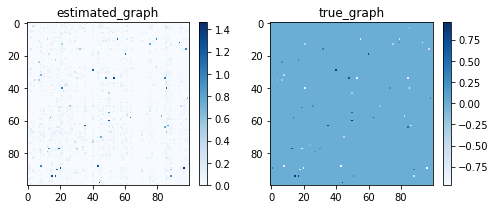

2022-04-13 14:02:20,960 INFO - __main__ - Thresholding.
2022-04-13 14:02:20,960 INFO - __main__ - Thresholding.
2022-04-13 14:02:20,960 INFO - __main__ - Thresholding.
2022-04-13 14:02:20,960 INFO - __main__ - Thresholding.
2022-04-13 14:02:20,960 INFO - __main__ - Thresholding.
2022-04-13 14:02:20,960 INFO - __main__ - Thresholding.


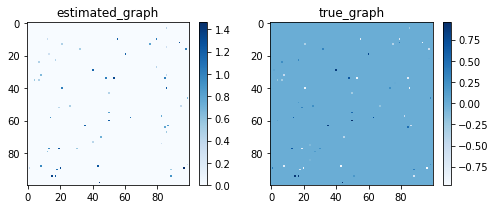

2022-04-13 14:02:21,345 INFO - __main__ - Results after thresholding by 0.3: {'fdr': 0.1724137931034483, 'tpr': 0.8, 'fpr': 0.002044989775051125, 'shd': 18, 'pred_size': 58}
2022-04-13 14:02:21,345 INFO - __main__ - Results after thresholding by 0.3: {'fdr': 0.1724137931034483, 'tpr': 0.8, 'fpr': 0.002044989775051125, 'shd': 18, 'pred_size': 58}
2022-04-13 14:02:21,345 INFO - __main__ - Results after thresholding by 0.3: {'fdr': 0.1724137931034483, 'tpr': 0.8, 'fpr': 0.002044989775051125, 'shd': 18, 'pred_size': 58}
2022-04-13 14:02:21,345 INFO - __main__ - Results after thresholding by 0.3: {'fdr': 0.1724137931034483, 'tpr': 0.8, 'fpr': 0.002044989775051125, 'shd': 18, 'pred_size': 58}
2022-04-13 14:02:21,345 INFO - __main__ - Results after thresholding by 0.3: {'fdr': 0.1724137931034483, 'tpr': 0.8, 'fpr': 0.002044989775051125, 'shd': 18, 'pred_size': 58}
2022-04-13 14:02:21,345 INFO - __main__ - Results after thresholding by 0.3: {'fdr': 0.1724137931034483, 'tpr': 0.8, 'fpr': 0.0020

In [10]:
#!/usr/bin/env python
# coding: utf-8



# !pip install torch
# !pip install --no-deps gcastle==1.0.3rc3
# !pip install pytz
# !pip install networkx
# !pip install pyyaml
# !pip install lingam
# !apt-get update && apt-get install -y graphviz 


import os
import time
from pytz import timezone
from datetime import datetime
import numpy as np

import logging
from helpers.config_utils import save_yaml_config, get_train_args
from helpers.log_helper import LogHelper
from helpers.tf_utils import set_seed
from helpers.dir_utils import create_dir
from helpers.analyze_utils import count_accuracy, plot_estimated_graph

import pandas as pd

LogHelper.setup(log_path='output/nt/training.log', level_str='INFO')
_logger = logging.getLogger(__name__)

def gogo(exp_name='n_500_d_5_e_3_ER'):
    

    
    start = time.time()

    # For logging of tensorflow messages
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    
    dataset_path = '../../experiment/datasets/{}/X.csv'.format(exp_name)
    true_path = '../../experiment/datasets/{}/W_true.csv'.format(exp_name)

    # headers = pd.read_csv(dataset_path, nrows=0).columns.tolist()
    # headers = [c for c in headers if c != 'Samples']
    # df = pd.read_csv(dataset_path, usecols=headers)

    df = pd.read_csv(dataset_path, header=None)
    X = df.to_numpy()

    headers = []
    for i in range(X.shape[1]):
        headers.append('x{}'.format(i))

    X.shape


    # In[5]:


    # Setup for logging
    output_dir = 'output/nt/{}'.format(exp_name)
    create_dir(output_dir)

    _logger.info('--- {} ---'.format(exp_name))

    # In[6]:


    from castle.algorithms import NotearsNonlinear

    nt = NotearsNonlinear(device_type='gpu', model_type='mlp', w_threshold=0.0)
    nt.learn(X)

    W_est = np.array(nt.weight_causal_matrix)
    W_est


    w_true = pd.read_csv(true_path, header=None)
    w_true = w_true.to_numpy()
    w_true


    # In[9]:


    # Save raw estimated graph, ground truth and observational data after training
    np.save('{}/true_graph.npy'.format(output_dir), w_true)
    np.save('{}/X.npy'.format(output_dir), X)
    np.save('{}/final_raw_estimated_graph.npy'.format(output_dir), W_est)


    # In[10]:


    # Plot raw estimated graph
    plot_estimated_graph(W_est, w_true,
                         save_name='{}/raw_estimated_graph.png'.format(output_dir))

    _logger.info('Thresholding.')
    # Plot thresholded estimated graph
    graph_thres = 0.3
    copy_W_est = np.copy(W_est)
    copy_W_est[np.abs(copy_W_est) < graph_thres] = 0   # Thresholding
    plot_estimated_graph(copy_W_est, w_true,
                         save_name='{}/thresholded_estimated_graph.png'.format(output_dir))
    results_thresholded = count_accuracy(w_true, copy_W_est)
    _logger.info('Results after thresholding by {}: {}'.format(graph_thres, results_thresholded))


    # In[11]:


    end = time.time()

    _logger.info('The time used to execute this is given below')
    _logger.info(end - start)


    # In[12]:


    c = np.sum(copy_W_est, axis=1)
    c.shape


    # In[13]:


    copy_W_est


    # In[14]:


    from lingam.utils import make_dot

    dot = make_dot(copy_W_est, labels=headers, lower_limit=0.5)

    # Save png
    dot.format = 'png'
    dag_path = dot.render('{}/dag'.format(output_dir))

    #dot.render('{}/dag'.format(output_dir))

    from IPython.display import Image
    Image(filename=dag_path) 


exp_name = [
# 'n_500_d_20_e_12_ER',
# 'n_500_d_20_e_12_SF',
'n_500_d_100_e_60_ER',
# 'n_500_d_100_e_60_SF',
# 'n_500_d_300_e_180_ER',
# 'n_500_d_300_e_180_SF',

# 'n_2000_d_20_e_12_ER',
# 'n_2000_d_20_e_12_SF',
# 'n_2000_d_100_e_60_ER',
# 'n_2000_d_100_e_60_SF',
# 'n_2000_d_300_e_180_ER',
# 'n_2000_d_300_e_180_SF',
]

for e_name in exp_name:
    print(e_name)
    gogo(e_name)

